In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from embedding_utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

# percentage of fully reconstructed smiles

### Data & Model Parameters

In [21]:
train_smiles, test_smiles = fetch_smiles_gdb13('./data/gdb13')

### Model

In [22]:
params = make_params(smiles=train_smiles + test_smiles, GRU_HIDDEN_DIM=512, LATENT_DIM=256)

In [23]:
encoder = Encoder(params)
encoder.load_state_dict(torch.load('weights-5/encoder_weights.pth'))

decoder = Decoder(params)
decoder.load_state_dict(torch.load('weights-5/decoder_weights.pth'))

<All keys matched successfully>

O=C1NCC2CN3C=[NH+]CCC13C2		OC12CC3OC1CN1CC2CCC31
O=C1NCC2CC3C=[NH+]CCC13C2		OC12CC3OC1CC1CC2CCC31
Euclidean Distance of Means: 11.779874801635742
Euclidean Distance of Samples: 11.773120880126953


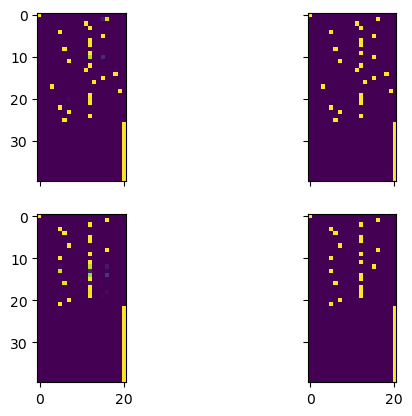

In [24]:
s1, s2 = random.sample(test_smiles, 2)
print(f'{s1}\t\t{s2}')

s1 = to_one_hot(s1, params)
s2 = to_one_hot(s2, params)

mu1, logvar1, z1 = encoder(s1)
mu2, logvar2, z2 = encoder(s2)

s1_pred = decoder(z1)
s2_pred = decoder(z2)

print(f'{from_one_hot(s1_pred, params)[0]}\t\t{from_one_hot(s2_pred, params)[0]}')

print(f"Euclidean Distance of Means: {float(torch.pow(torch.sum(torch.pow(mu1 - mu2, 2)), 0.5))}")
print(f"Euclidean Distance of Samples: {float(torch.pow(torch.sum(torch.pow(z1 - z2, 2)), 0.5))}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

ax1.imshow(torch.softmax(s1_pred, dim=2).squeeze(0).detach().numpy())
ax2.imshow(torch.softmax(s1, dim=2).squeeze(0).detach().numpy())

ax3.imshow(torch.softmax(s2_pred, dim=2).squeeze(0).detach().numpy())
ax4.imshow(torch.softmax(s2, dim=2).squeeze(0).detach().numpy())

## Test

In [25]:
evaluate_ae(encoder, decoder, test_smiles, 10, params=params)

,target,predicted
0,C1CC2C3[NH2+]C4CC3OC2(C4)O1,C1CC2C3[NH2+]C4CC3OC2(C4)O1
1,C1CN2N=CC=C2C2=C(N1)C=NN2,C1CN2N=CC=C2C2=C(N1)C=NN2
2,C1[NH2+]C2CN3CC4NC(C3)C2OC14,C1[NH2+]C2CN3CC4CC(C3)C2OC14
3,O=C1C2NC3C4C(CCC24)C[NH2+]C13,O=C1C2NC3C4C(CCC24)C[NH2+]C13
4,[NH3+]C12COC3(CCCC13)CCC2,[NH3+]C12COC3(CCCC13)CCC2
5,C1CC2COCC3CC[NH2+]C1CC23,C1CC2COCC3CC[NH2+]C1CC23
6,OC1=C2CC3=NNC=C3CN2C=C1,OC1=C2CC3=CSC=C3CN2C=C1
7,C1CC2CCC1CN1N=CC=C1C2,C1CC2CCC1CN1N=CC=C1C2
8,OC1CC2CC3C[NH+]2CC(O)(C3)C1,OC1CC2CC3C[NH+]2CC(O))C3)C1
9,OC12C3CCC1C(CC2=O)CCC3,OC12C3CCC1C(C31=O)CCC3


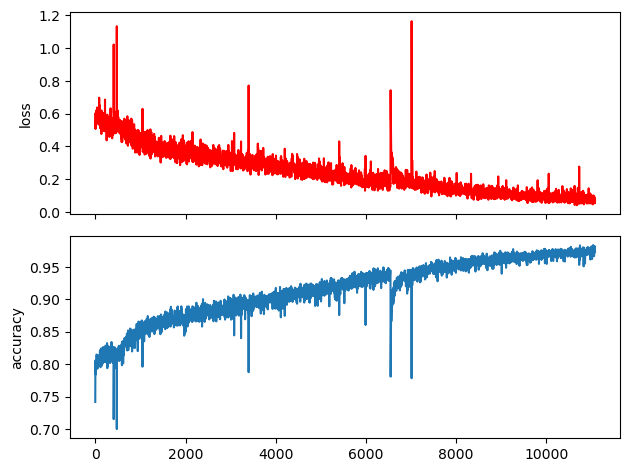

In [27]:
log = pd.read_csv('./logs/log-5.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

every = 3

ax1.set_ylabel('loss')
ax1.plot(log['loss'][::every], color='red')

ax2.set_ylabel('accuracy')
ax2.plot(log['similarity'][::every])

plt.tight_layout()